In [1]:
import os
import cv2 as cv
import numpy as np
from doctr.models import ocr_predictor
from inspection.support.utils import extract
from skimage.io import imshow
import imutils 
import pytesseract

/media/egor/T7/vut_dp_project_workspace/source/playground/.venv.doctr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-18 18:06:57.362971: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 18:06:58.561892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 18:06:58.562097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 18:06:58.759675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Att

In [2]:
model = ocr_predictor(det_arch='linknet_resnet34', reco_arch='crnn_vgg16_bn', pretrained=True, preserve_aspect_ratio=True)

In [146]:
OCR_MASK_COLOR = np.array([255, 0, 0])
ORIGINAL = "./inspection/support/um_camera/drawcore.bmp"
MASK = "./inspection/support/ocr/drawcore/r22_0.bmp"
TEXT = ".".join(os.path.basename(MASK).split(".")[:-1]).split('_')[0]

print(f"Detecting: '{TEXT}' at image: {ORIGINAL} under mask {MASK}")

Detecting: 'r22' at image: ./inspection/support/um_camera/drawcore.bmp under mask ./inspection/support/ocr/drawcore/r22_0.bmp


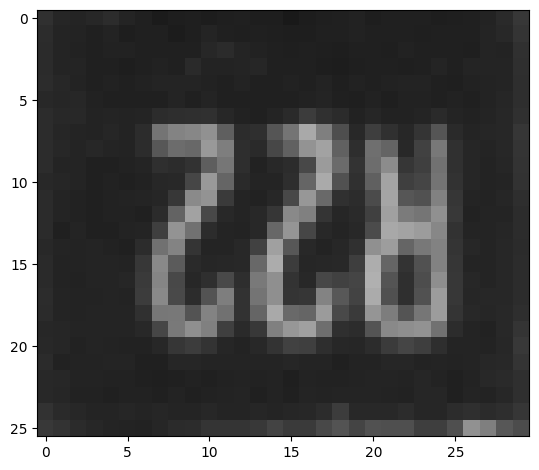

In [147]:
original = cv.cvtColor(
    cv.imread(ORIGINAL),
    cv.COLOR_BGR2GRAY,
)
mask = cv.cvtColor(
    cv.imread(MASK),
    cv.COLOR_BGR2RGB,
)
chunks, values = extract(original, OCR_MASK_COLOR, mask)
imshow(chunks[0])

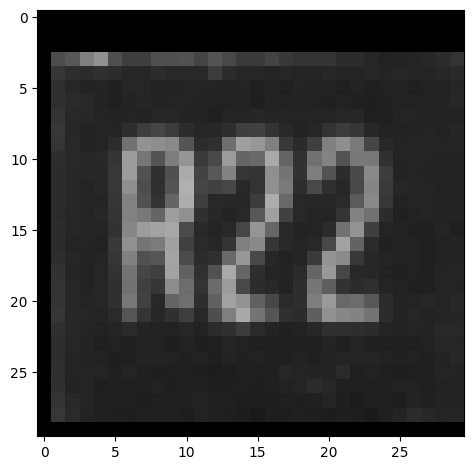

In [149]:
# Make image squared to support rotation
base = chunks[0]
im = imutils.resize(base, height=50)

s = max(base.shape)

r = s
c = s
box = np.zeros((r, c))
r = int(r / 2) - int(base.shape[0] / 2)
c = int(c / 2) - int(base.shape[1] / 2)
box[r : r + base.shape[0], c : c + base.shape[1]] = base
base = box.astype(np.uint8)
base = imutils.rotate(base, 180)

imshow(base)

## Tesseract
Tesseract handles OCR in most cases, but fails with zeros with diagonal line for example (technical font).

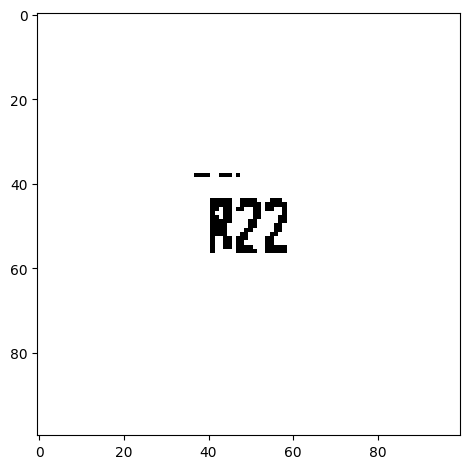

In [168]:
im = base
_, im = cv.threshold(im, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

r = 100
c = 100
box = np.zeros((r, c))
# print(im.shape)
r = int(r / 2) - int(im.shape[0] / 2)
c = int(c / 2) - int(im.shape[1] / 2)
box[r : r + im.shape[0], c : c + im.shape[1]] = im
box = 255 - box
im = box.astype(np.uint8)


im = cv.cvtColor(
    im,
    cv.COLOR_GRAY2RGB,
)

imshow(im)

In [160]:
%%timeit
out = pytesseract.image_to_string(im)

334 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [169]:
pytesseract.image_to_string(im)

'R22\n\x0c'

## DocTR
DocTR use double arch OCR model: first it detects text on image and then recognize characters. Text detection require some space on image (does not work if text fills whole space on image).

In [10]:
import tensorflow as tf
from doctr.models import crnn_vgg16_bn

In [11]:
model = crnn_vgg16_bn(pretrained=True)

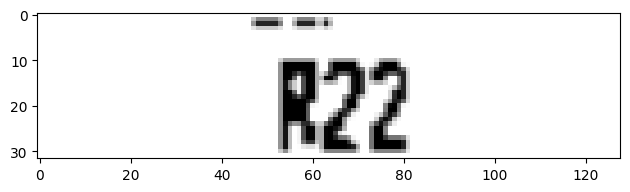

In [155]:
def trim_zero_rows_and_cols(arr):
    # Find the index of the first non-zero element in each row
    row_sums = np.sum(arr != 0, axis=1)
    first_nonzero_row = np.argmax(row_sums > 0)

    # Find the index of the first non-zero element in each column
    col_sums = np.sum(arr != 0, axis=0)
    first_nonzero_col = np.argmax(col_sums > 0)

    # Find the index of the last non-zero element in each row
    last_nonzero_row = arr.shape[0] - 1 - np.argmax(row_sums[::-1] > 0)

    # Find the index of the last non-zero element in each column
    last_nonzero_col = arr.shape[1] - 1 - np.argmax(col_sums[::-1] > 0)

    # Slice the array to keep rows and columns between the first and last non-zero indices
    trimmed_arr = arr[
        first_nonzero_row : last_nonzero_row + 1,
        first_nonzero_col : last_nonzero_col + 1,
    ]

    return trimmed_arr


def pad_array(arr):
    # Pad 2 rows of zeros at the top and bottom
    padded_arr = np.pad(arr, ((1, 1), (1, 1)), mode="constant", constant_values=0)
    return padded_arr


def image_normalization(im: np.ndarray, input_shape=(32, 128)):
    # Apply first threshold to remove background and trim empty space
    _, im = cv.threshold(im, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    im = trim_zero_rows_and_cols(im)
    im = pad_array(im)

    if 1.2 > im.shape[0] / im.shape[1] > 0.8:  # Arbitrary selected
        # Image seems to be square, do not resize to input size (but to max allowed by input), but put
        # into box in center to fit input size of model
        k = input_shape[0] / im.shape[0]
        im = cv.resize(im, (0, 0), fx=k, fy=k)
        r, c = input_shape
        box = np.zeros(input_shape)
        r = int(r / 2) - int(im.shape[0] / 2)
        c = int(c / 2) - int(im.shape[1] / 2)
        box[r : r + im.shape[0], c : c + im.shape[1]] = im
        box = 255 - box
        im = box.astype(np.uint8)
    else:
        if im.shape[0] / im.shape[1] > 1.2:  # Arbitrary selected
            # Rotate vertical images
            im = imutils.rotate(im, 90)
        im = cv.resize(im, (input_shape[1], input_shape[0]))

    im = cv.cvtColor(
        im,
        cv.COLOR_GRAY2RGB,
    )
    return im


im = image_normalization(base)
imshow(im)

In [156]:
%%timeit
im_tf = np.expand_dims(1 - (im/255), 0)
im_tf = tf.convert_to_tensor(im_tf)
out = model(im_tf)

495 ms ± 81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
out

{'preds': [('R22', 0.9677000641822815)]}